✅ First page saved as: page_1.png


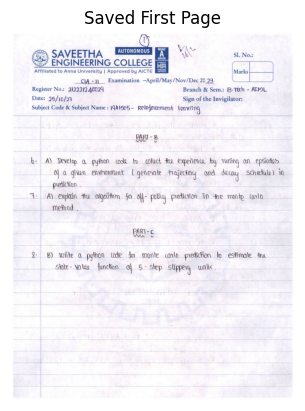

In [19]:
import albumentations as A
import cv2
import numpy as np
from pdf2image import convert_from_path
import matplotlib.pyplot as plt

# Convert the first page of the PDF to an image
pdf_path = "PDF Samples/00004_212221240029_19AI505_CIA2.pdf"
pages = convert_from_path(pdf_path, dpi=300)

# Convert PIL image to OpenCV format (BGR)
image = cv2.cvtColor(np.array(pages[0]), cv2.COLOR_RGB2BGR)

# Save the image
output_image_path = "page_1.png"
cv2.imwrite(output_image_path, image)
print(f"✅ First page saved as: {output_image_path}")

# (Optional) Display the saved image using matplotlib
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Saved First Page")
plt.axis("off")
plt.show()


In [20]:
# Define crop manually (x_min, y_min, width, height)
crop_box = (500, 470, 500, 90)  # <-- you adjust this
crop = A.Crop(x_min=crop_box[0], y_min=crop_box[1],
              x_max=crop_box[0]+crop_box[2], y_max=crop_box[1]+crop_box[3])

cropped_image = crop(image=image)["image"]


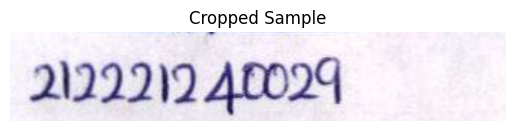

In [21]:
# Save or visualize
cv2.imwrite("cropped_sample.jpg", cropped_image)
plt.imshow(cv2.cvtColor(cropped_image, cv2.COLOR_BGR2RGB))
plt.title("Cropped Sample")
plt.axis("off")
plt.show()


In [22]:
import torch
import torch.nn as nn
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

# ----- CRNN Model -----
class CRNN(nn.Module):
    def __init__(self, num_classes):
        super(CRNN, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, 1, 1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.3),
            nn.Conv2d(128, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Conv2d(256, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1), nn.BatchNorm2d(512), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
            nn.Dropout2d(0.3),
            nn.Conv2d(512, 512, (2, 1)), nn.BatchNorm2d(512), nn.ReLU()
        )
        self.rnn = nn.LSTM(512, 256, num_layers=2, bidirectional=True, dropout=0.3)
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        x = x.squeeze(2)  # (N, 512, W/4)
        x = x.permute(2, 0, 1)  # (W/4, N, 512)
        x, _ = self.rnn(x)
        x = self.dropout(x)
        x = self.fc(x)  # (W/4, N, num_classes)
        return x

# ----- Device Setup -----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# ----- Load Model -----
model_path = 'best_crnn_model.pth'  # <- Put your model path here
model = CRNN(num_classes=11).to(device)

try:
    checkpoint = torch.load(model_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    print(f"✅ Model loaded successfully from epoch {checkpoint['epoch']} with val acc: {checkpoint['val_accuracy']:.2f}%")
except Exception as e:
    print(f"❌ Error loading model: {e}")


✅ Model loaded successfully from epoch 62 with val acc: 93.83%


In [23]:
# ----- Image Transform (must match training/validation) -----
transform = transforms.Compose([
    transforms.Resize((32, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])



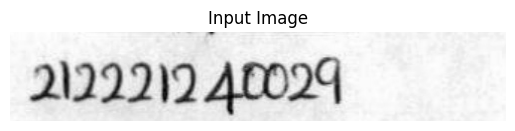


📌 Predicted Register Number: 212221240029


In [24]:

# ----- Prediction Function -----
def predict_register_number(model, image_path, transform):
    image = Image.open(image_path).convert('L')
    plt.imshow(image, cmap='gray')
    plt.title("Input Image")
    plt.axis('off')
    plt.show()

    image_tensor = transform(image).unsqueeze(0).to(device)  # (1, 1, 32, 256)
    with torch.no_grad():
        output = model(image_tensor).squeeze(1)
        pred = output.softmax(1).argmax(1).cpu().numpy()

    # Decode CTC-style predictions
    prev = -1
    result = []
    for s in pred:
        if s != 0 and s != prev:
            result.append(s - 1)
        prev = s

    return ''.join(map(str, result))

# ----- Run Prediction -----
image_path = 'cropped_sample.jpg'  # <- Replace with your actual test image path
if os.path.exists(image_path):
    predicted = predict_register_number(model, image_path, transform)
    print(f"\n📌 Predicted Register Number: {predicted}")
else:
    print(f"❌ Image not found: {image_path}")

# Region Detection


In [25]:
from pdf2image import convert_from_path, pdfinfo_from_path
import os
from PIL import Image

pdf_folder = "PDF Samples"
output_folder = "images"
os.makedirs(output_folder, exist_ok=True)

def is_valid_pdf(pdf_path):
    try:
        info = pdfinfo_from_path(pdf_path)
        return True
    except Exception:
        return False

converted = 0
for pdf_file in sorted(os.listdir(pdf_folder)):
    if pdf_file.lower().endswith(".pdf"):
        pdf_path = os.path.join(pdf_folder, pdf_file)
        if not is_valid_pdf(pdf_path):
            print(f"❌ Skipping invalid PDF: {pdf_file}")
            continue
        try:
            pages = convert_from_path(pdf_path, dpi=300, first_page=1, last_page=1)
            image = pages[0]
            img_filename = os.path.splitext(pdf_file)[0] + ".jpg"
            image.save(os.path.join(output_folder, img_filename), "JPEG")
            print(f"✅ Converted: {img_filename}")
            converted += 1
            if converted == 10:
                break
        except Exception as e:
            print(f"⚠️ Error converting {pdf_file}: {e}")

print(f"\n✅ Done! Converted {converted} valid PDFs to images.")


✅ Converted: 00001_212220040089_19CS523_CIA3.jpg
✅ Converted: 00001_212220040098_19CS409_CIA2.jpg
✅ Converted: 00001_212220040165_19CS417_CIA2.jpg
❌ Skipping invalid PDF: 00001_212220043003_19CS414_CIA2.pdf
✅ Converted: 00001_212220220020_19CS504_CIA2.jpg
✅ Converted: 00001_212220220031_19CS504_CIA2.jpg
❌ Skipping invalid PDF: 00001_212220220042_19CS409_CIA3.pdf
✅ Converted: 00001_212220230026_19MS155_CIA2.jpg
✅ Converted: 00001_212221040002_19CS414_CIA2.jpg
✅ Converted: 00001_212221040027_19EE305_CIA3.jpg
✅ Converted: 00001_212221040029_19CS409_CIA3.jpg
✅ Converted: 00001_212221040042_19AI412_CIA3.jpg

✅ Done! Converted 10 valid PDFs to images.


In [26]:


import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt



In [27]:
images = tf.data.Dataset.list_files('data/images/*.jpg')

In [28]:
images.as_numpy_iterator().next()


b'data/images/00001_212221040029_19CS409_CIA3.jpg'

In [29]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [30]:
images = images.map(load_image)

images.as_numpy_iterator().next()

type(images)



tensorflow.python.data.ops.map_op._MapDataset

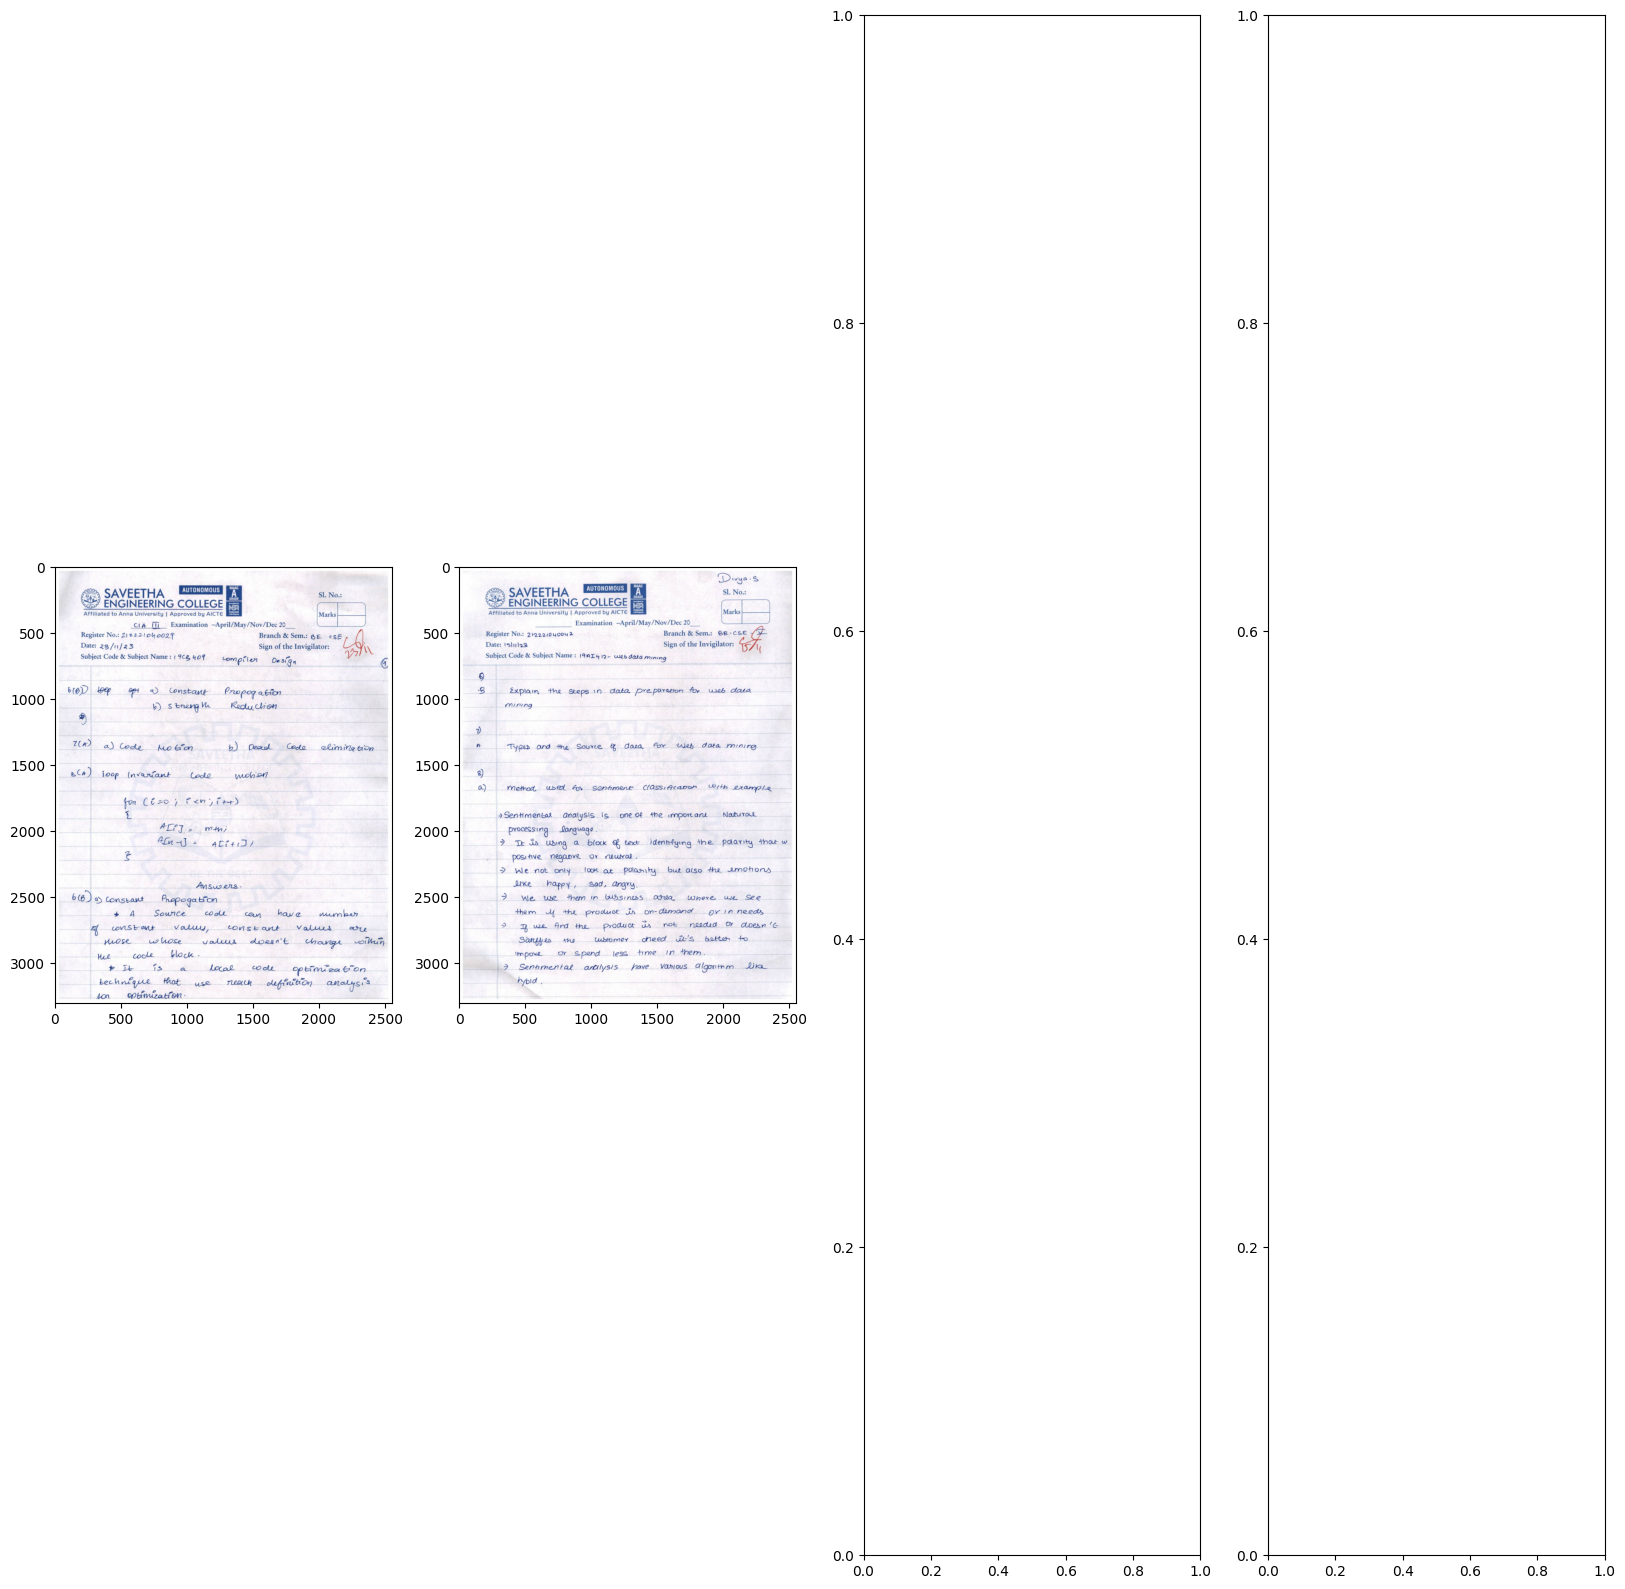

In [31]:
image_generator = images.batch(4).as_numpy_iterator()

plot_images = image_generator.next()

fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()



In [32]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

In [33]:


import albumentations as alb



In [34]:
augmentor = alb.Compose([alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))


In [35]:


img = cv2.imread(os.path.join('data','train', 'images','00001_212220040098_19CS409_CIA2.jpg'))



In [36]:
with open(os.path.join('data', 'train', 'labels', '00001_212220040098_19CS409_CIA2.json'), 'r') as f:
    label = json.load(f)

In [37]:
label['shapes'][0]['points']

[[497.64705882352945, 535.1176470588234],
 [1038.8235294117646, 632.7647058823529]]

In [38]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]


In [39]:
coords

[497.64705882352945, 535.1176470588234, 1038.8235294117646, 632.7647058823529]

In [40]:


coords = list(np.divide(coords, [2552,3302,2552,3302]))



In [41]:
coords

[np.float64(0.19500276599668082),
 np.float64(0.16205864538425907),
 np.float64(0.4070625115249861),
 np.float64(0.1916307407275448)]

In [42]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['reg_no'])


In [43]:


augmented['bboxes']



[[0.5929374992847443,
  0.16205865144729614,
  0.8049972355365753,
  0.19163073599338531]]

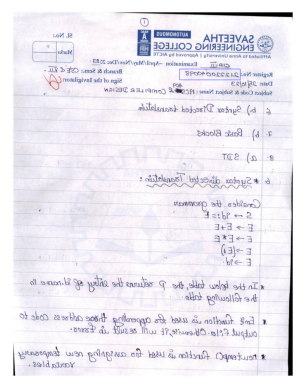

In [44]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assume augmented is your albumentations output
img = augmented['image']
bboxes = augmented.get('bboxes', [])

# Only draw if bbox exists
if bboxes:
    h, w = img.shape[:2]  # Get actual height and width of image
    x_min = int(bboxes[0][0] * w)
    y_min = int(bboxes[0][1] * h)
    x_max = int(bboxes[0][2] * w)
    y_max = int(bboxes[0][3] * h)

    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (255, 0, 0), 2)
else:
    print("⚠️ No bounding box found after augmentation!")

# Show the image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


In [45]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [2552,3302,2552,3302]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['reg_no'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)


In [46]:


train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)



In [47]:


test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)



In [48]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [49]:


train_images.as_numpy_iterator().next()



array([[[0.92941177, 0.92941177, 0.92941177],
        [0.92941177, 0.92941177, 0.92941177],
        [0.92941177, 0.92941177, 0.92941177],
        ...,
        [0.92941177, 0.92941177, 0.92941177],
        [0.92941177, 0.92941177, 0.92941177],
        [0.92941177, 0.92941177, 0.92941177]],

       [[0.92941177, 0.92941177, 0.92941177],
        [0.9019608 , 0.9019608 , 0.9050981 ],
        [0.905     , 0.9010784 , 0.9246078 ],
        ...,
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.92941177, 0.92941177, 0.92941177]],

       [[0.92941177, 0.92941177, 0.92941177],
        [0.8725817 , 0.8694445 , 0.8741503 ],
        [0.8995098 , 0.89166665, 0.90343136],
        ...,
        [0.00277779, 0.00277779, 0.00277779],
        [0.        , 0.        , 0.        ],
        [0.92941177, 0.92941177, 0.92156863]],

       ...,

       [[0.92941177, 0.92941177, 0.92941177],
        [0.        , 0.        , 0.        ],
        [0.8964059 , 0

In [50]:


def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']



In [51]:


train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [52]:


test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [53]:


val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))



In [54]:


train_labels.as_numpy_iterator().next()



2025-04-11 17:32:32.615538: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


(array([1], dtype=uint8),
 array([0.593 , 0.1621, 0.805 , 0.1917], dtype=float16))

In [55]:


train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)



In [56]:


test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)



In [57]:


val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)



In [58]:


train.as_numpy_iterator().next()[1]



(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.1948, 0.143 , 0.4182, 0.1711],
        [0.593 , 0.1621, 0.805 , 0.1917],
        [0.557 , 0.1403, 0.8066, 0.1685],
        [0.1948, 0.143 , 0.4182, 0.1711],
        [0.593 , 0.8086, 0.805 , 0.838 ],
        [0.557 , 0.1403, 0.8066, 0.1685],
        [0.557 , 0.8315, 0.8066, 0.86  ],
        [0.1962, 0.826 , 0.4084, 0.861 ]], dtype=float16))

In [59]:


data_samples = train.as_numpy_iterator()



In [60]:


res = data_samples.next()



In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16


In [62]:
vgg = VGG16(include_top=False)


In [63]:


vgg.summary()



Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

In [65]:
facetracker = build_model()

facetracker.summary()

X, y = train.as_numpy_iterator().next()

X.shape

classes, coords = facetracker.predict(X)

classes, coords



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      2,049 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 4)         │      8,196 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step


(array([[0.311585  ],
        [0.32486066],
        [0.30034676],
        [0.3263481 ],
        [0.28354678],
        [0.29952246],
        [0.32140103],
        [0.30372116]], dtype=float32),
 array([[0.44854835, 0.56490517, 0.4532386 , 0.36983958],
        [0.4441675 , 0.58489597, 0.42442942, 0.45137316],
        [0.44261152, 0.59715724, 0.44311252, 0.45480368],
        [0.41486984, 0.6057726 , 0.4314898 , 0.3155644 ],
        [0.3997765 , 0.59170127, 0.4341074 , 0.37331283],
        [0.4326624 , 0.6127832 , 0.4756192 , 0.44567123],
        [0.454215  , 0.5881896 , 0.4368161 , 0.3698888 ],
        [0.46755147, 0.62135994, 0.45817703, 0.34321195]], dtype=float32))

In [66]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch


In [67]:


opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)



/home/kavinraja/Ml-projects/Register-Number-and-Subject-Code-Recognition-main-2/Register-Number-and-Subject-Code-Recognition-main/myenv/lib64/python3.11/site-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [68]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [69]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

In [70]:
localization_loss(y[1], coords)



<tf.Tensor: shape=(), dtype=float32, numpy=2.2286877632141113>

In [71]:


classloss(y[0], classes)



<tf.Tensor: shape=(), dtype=float32, numpy=1.175713062286377>

In [72]:


regressloss(y[1], coords)



<tf.Tensor: shape=(), dtype=float32, numpy=2.2286877632141113>

In [73]:
#Custom Model
import tensorflow as tf
from tensorflow.keras.models import Model

class FaceTracker(Model):
    def __init__(self, eyetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.opt = opt
        self.closs = classloss
        self.lloss = localizationloss

    @tf.function
    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            try:
                classes, coords = self.model(X, training=True)
                y_0 = tf.reshape(y[0], [-1, 1])

                batch_classloss = self.closs(y_0, classes)
                batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)

                total_loss = batch_localizationloss + 0.5 * batch_classloss

            except tf.errors.InvalidArgumentError as e:
                if 'Input tensors must be of size at least 1' in str(e):
                    return {"total_loss": tf.constant(0.0)} 
                else:
                    raise e 

            grads = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grads, self.model.trainable_variables))

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training=False)

        y_0 = tf.reshape(y[0], [-1, 1])

        batch_classloss = self.closs(y_0, classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)


        total_loss = batch_localizationloss + 0.5 * batch_classloss

        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}

    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [74]:
model = FaceTracker(facetracker)

In [75]:
model.compile(opt,classloss, regressloss)
     

In [76]:


# Use gpu it took lot of time and increase the epochs
hist = model.fit(train, epochs=5, validation_data=val)
     


Epoch 1/5


I0000 00:00:1744373003.142657    5795 service.cc:152] XLA service 0x7f64f806dfa0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744373003.142699    5795 service.cc:160]   StreamExecutor device (0): Host, Default Version
I0000 00:00:1744373003.233470    5795 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 72s 2s/step - class_loss: 0.1116 - regress_loss: 0.4886 - total_loss: 0.5444 - val_class_loss: 1.0100e-04 - val_regress_loss: 0.1129 - val_total_loss: 0.1130
Epoch 2/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 81s 2s/step - class_loss: 2.1768e-04 - regress_loss: 0.0154 - total_loss: 0.0155 - val_class_loss: 5.3462e-05 - val_regress_loss: 0.0438 - val_total_loss: 0.0438
Epoch 3/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - class_loss: 1.3764e-04 - regress_loss: 0.0041 - total_loss: 0.0041 - val_class_loss: 5.3072e-05 - val_regress_loss: 0.0306 - val_total_loss: 0.0307
Epoch 4/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 68s 2s/step - class_loss: 4.7008e-05 - regress_loss: 0.0016 - total_loss: 0.0016 - val_class_loss: 2.1055e-05 - val_regress_loss: 0.0641 - val_total_loss: 0.0641
Epoch 5/5
38/38 ━━━━━━━━━━━━━━━━━━━━ 73s 2s/step - class_loss: 2.5454e-05 - regress_loss: 0.0013 - total_loss: 0.0013 - val_class_loss: 1.2581e-05 - val_regress_loss: 0.0721 - val_total_loss: 0.0721


In [77]:
test_data = test.as_numpy_iterator()

In [78]:
test_sample = test_data.next()


In [79]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


In [81]:
from tensorflow.keras.models import load_model

facetracker.save('r.h5')

facetracker = load_model('r.h5')




In [82]:
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [83]:
facetracker = tf.keras.models.load_model("r.h5")  # Replace with your model


In [84]:
img_path = "page_1.png"
frame = cv2.imread(img_path)
original_height, original_width = frame.shape[:2]  # 3302 x 2552

# Convert BGR to RGB
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Resize only for model input
resized = tf.image.resize(rgb, (120, 120)) / 255.0

# =========================
# Run Prediction
# =========================
yhat = facetracker.predict(np.expand_dims(resized, axis=0))
confidence = yhat[0][0]
sample_coords = yhat[0][1:]  # [x_min, y_min, x_max, y_max] in normalized values

# =========================
# Draw Box if Confidence Passes
# =========================
if confidence > 0.5:
    top_left = tuple(np.multiply(sample_coords[:2], [original_width, original_height]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [original_width, original_height]).astype(int))

    # Draw main box
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 5)

    # Draw label background
    label_top = tuple(np.add(top_left, [0, -40]))
    label_bottom = tuple(np.add(top_left, [300, 0]))
    cv2.rectangle(frame, label_top, label_bottom, (255, 0, 0), -1)

    # Put label text
    cv2.putText(frame, 'Reg Number', tuple(np.add(top_left, [0, -10])),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA)

# =========================
# Show the Output Image
# =========================
cv2.imshow("Register Number Detection", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step


error: OpenCV(4.11.0) :-1: error: (-5:Bad argument) in function 'rectangle'
> Overload resolution failed:
>  - Can't parse 'pt1'. Expected sequence length 2, got 0
>  - Can't parse 'rec'. Expected sequence length 4, got 0
>  - Can't parse 'pt1'. Expected sequence length 2, got 0
>  - Can't parse 'rec'. Expected sequence length 4, got 0


In [86]:
import cv2
import numpy as np
import tensorflow as tf

# Load image
img_path = "page_1.png"
frame = cv2.imread(img_path)
original_height, original_width = frame.shape[:2]

# Convert to RGB
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Resize for model input
resized = tf.image.resize(rgb, (120, 120)) / 255.0

# Run model prediction
yhat = facetracker.predict(np.expand_dims(resized, axis=0))
confidence = yhat[0][0]
sample_coords = yhat[0][1:]

# Validate output
if (
    confidence > 0.5 and
    isinstance(sample_coords, (list, np.ndarray)) and
    len(sample_coords) == 4 and
    not np.any(np.isnan(sample_coords)) and
    not np.any(np.isinf(sample_coords))
):
    # Convert to actual pixel values
    top_left = tuple(np.multiply(sample_coords[:2], [original_width, original_height]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [original_width, original_height]).astype(int))

    # Draw bounding box
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 5)

    # Draw label background
    label_top = tuple(np.add(top_left, [0, -40]))
    label_bottom = tuple(np.add(top_left, [300, 0]))
    cv2.rectangle(frame, label_top, label_bottom, (255, 0, 0), -1)

    # Label text
    cv2.putText(frame, 'Reg Number', tuple(np.add(top_left, [0, -10])),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA)
else:
    print("⚠️ No confident prediction or invalid coordinates:", sample_coords)

# Show image
cv2.imshow("Register Number Detection", frame)
cv2.waitKey(0)
cv2.destroyAllWindows()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
⚠️ No confident prediction or invalid coordinates: []


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [87]:
import cv2
import numpy as np
import tensorflow as tf

# Load image
img_path = "page_1.png"
frame = cv2.imread(img_path)
original_height, original_width = frame.shape[:2]

# Convert to RGB
rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

# Resize only for model input
resized = tf.image.resize(rgb, (120, 120)) / 255.0

# Run model prediction
yhat = facetracker.predict(np.expand_dims(resized, axis=0))
confidence = yhat[0][0]
sample_coords = yhat[0][1:]

# Validate prediction
if (
    confidence > 0.5 and
    isinstance(sample_coords, (list, np.ndarray)) and
    len(sample_coords) == 4 and
    not np.any(np.isnan(sample_coords)) and
    not np.any(np.isinf(sample_coords))
):
    # Convert normalized coords to image scale
    top_left = tuple(np.multiply(sample_coords[:2], [original_width, original_height]).astype(int))
    bottom_right = tuple(np.multiply(sample_coords[2:], [original_width, original_height]).astype(int))

    # Draw bounding box
    cv2.rectangle(frame, top_left, bottom_right, (255, 0, 0), 5)

    # Draw label background
    label_top = tuple(np.add(top_left, [0, -40]))
    label_bottom = tuple(np.add(top_left, [300, 0]))
    cv2.rectangle(frame, label_top, label_bottom, (255, 0, 0), -1)

    # Put label text
    cv2.putText(frame, 'Reg Number', tuple(np.add(top_left, [0, -10])),
                cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 4, cv2.LINE_AA)

    # Save the image with bounding box
    cv2.imwrite("detected_output.png", frame)
    print("✅ Image saved as 'detected_output.png'")
else:
    print("⚠️ No confident prediction or invalid coordinates:", sample_coords)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
⚠️ No confident prediction or invalid coordinates: []


In [18]:
import cv2

img = cv2.imread("page_1.jpg")
cv2.imshow("Image", img)
cv2.waitKey(0)
cv2.destroyAllWindows()


[ WARN:0@1567.461] global loadsave.cpp:268 findDecoder imread_('page_1.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:973: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'imshow'


In [17]:


cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'reg_no', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


error: OpenCV(4.11.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


In [4]:
import os
import json

input_json_dir = 'aug_data/train/labels'
output_yolo_dir = 'aug_data/train/labels_yolo'

os.makedirs(output_yolo_dir, exist_ok=True)

for file in os.listdir(input_json_dir):
    if not file.endswith(".json"):
        continue

    with open(os.path.join(input_json_dir, file), 'r') as f:
        data = json.load(f)

    bbox = data["bbox"]  # [x_min, y_min, x_max, y_max]
    cls = data["class"]

    # Convert (x_min, y_min, x_max, y_max) => YOLO (x_center, y_center, width, height)
    x_min, y_min, x_max, y_max = bbox
    x_center = (x_min + x_max) / 2
    y_center = (y_min + y_max) / 2
    width = abs(x_max - x_min)
    height = abs(y_max - y_min)

    yolo_format = f"{cls} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"

    # Save as .txt with same filename
    out_path = os.path.join(output_yolo_dir, file.replace(".json", ".txt"))
    with open(out_path, "w") as out_file:
        out_file.write(yolo_format + "\n")

print("✅ YOLO label conversion complete.")


✅ YOLO label conversion complete.


In [14]:
import torch
from pathlib import Path
from yolov5.models.yolo import Model
from yolov5.utils.dataloaders import create_dataloader
from yolov5.utils.torch_utils import select_device
from yolov5.utils.general import increment_path
from yolov5.utils.loss import ComputeLoss

# Choose device (GPU or CPU)
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')

# Create Model (YOLOv5)
model = Model(cfg='yolov5/models/yolov5s.yaml', ch=3, nc=1).to(device)

# Load the dataset
train_dataset = create_dataloader(Path('aug_data/train/images'), imgsz=3500, batch_size=16, stride=32, rect=False, workers=4)[0]
val_dataset = create_dataloader(Path('aug_data/val/images'), imgsz=3500, batch_size=16, stride=32, rect=False, workers=4)[0]
# Set up loss
compute_loss = ComputeLoss(model)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.937, weight_decay=5e-4)

# Set number of epochs
epochs = 50


YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU



Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               
  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]             

AttributeError: 'DetectionModel' object has no attribute 'hyp'

ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 ERROR: Unexpected bus error encountered in worker. This might be caused by insufficient shared memory (shm).
 

In [2]:
import torch
import numpy as np
from pathlib import Path
from yolov5.models.yolo import Model
from yolov5.utils.dataloaders import create_dataloader
from yolov5.utils.torch_utils import select_device
from yolov5.utils.loss import ComputeLoss
import yaml
import os

# Choose device (GPU or CPU)
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')

# Load hyperparameters
with open('yolov5/data/hyps/hyp.scratch-med.yaml', 'r') as f:
    hyp = yaml.safe_load(f)

# Create Model (YOLOv5) with 1 class (e.g., text regions)
model = Model(cfg='yolov5/models/yolov5s.yaml', ch=3, nc=1, hyp=hyp).to(device)

# Image size and original dimensions
imgsz = 640  # Target image size
orig_width, orig_height = 2552, 3302  # Original image dimensions

# Function to adjust coordinates if needed
def adjust_labels(label_dir, orig_w, orig_h, target_sz):
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            file_path = os.path.join(label_dir, label_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
            with open(file_path, 'w') as f:
                for line in lines:
                    data = line.strip().split()
                    class_id = int(data[0])
                    coords = np.array(list(map(float, data[1:])))
                    # Assuming coords are already normalized to orig_w, orig_h
                    # Rescale to target_sz
                    new_coords = coords * [target_sz / orig_w, target_sz / orig_h, target_sz / orig_w, target_sz / orig_h]
                    new_line = f"{class_id} {' '.join(map(str, new_coords))}\n"
                    f.write(new_line)

# Adjust labels if needed
train_label_dir = Path('aug_data/train/labels_yolo')
adjust_labels(train_label_dir, orig_width, orig_height, imgsz)
val_label_dir = Path('aug_data/val/labels')
adjust_labels(val_label_dir, orig_width, orig_height, imgsz)

# Load the dataset
train_dataset = create_dataloader(
    Path('aug_data/train/images'),
    imgsz=imgsz,
    batch_size=16,
    stride=32,
    rect=False,
    workers=1,  # Reduced workers to avoid bus errors
    pad=0.5
)[0]
val_dataset = create_dataloader(
    Path('aug_data/val/images'),
    imgsz=imgsz,
    batch_size=16,
    stride=32,
    rect=False,
    workers=1,
    pad=0.5
)[0]

# Set up loss
compute_loss = ComputeLoss(model, autobalance=False)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.937, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Set number of epochs
epochs = 50

# Training loop
for epoch in range(epochs):
    model.train()
    for batch_idx, (images, targets, paths, _) in enumerate(train_dataset):
        images = images.to(device)
        targets = targets.to(device)
        
        # Forward pass
        pred = model(images)
        loss, loss_items = compute_loss(pred, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    scheduler.step()
    print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')

print("Training completed!")

YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU



TypeError: DetectionModel.__init__() got an unexpected keyword argument 'hyp'

In [9]:
import torch
import numpy as np
from pathlib import Path
from yolov5.models.yolo import Model
from yolov5.utils.dataloaders import create_dataloader, LoadImages
from yolov5.utils.torch_utils import select_device
from yolov5.utils.loss import ComputeLoss
import yaml
import os
from yolov5.utils.general import non_max_suppression, scale_boxes
from tqdm import tqdm  # Import tqdm for progress bar

# Choose device (GPU or CPU)
device = select_device('cuda' if torch.cuda.is_available() else 'cpu')

# Load hyperparameters from hyp.scratch-med.yaml
with open('yolov5/data/hyps/hyp.scratch-med.yaml', 'r') as f:
    hyp = yaml.safe_load(f)

# Create or load Model (YOLOv5) with 1 class (e.g., text regions)
model = Model(cfg='yolov5/models/yolov5s.yaml', ch=3, nc=1).to(device)
model.hyp = hyp  # Manually attach hyperparameters to the model

# Image size and original dimensions
imgsz = 640  # Target image size
orig_width, orig_height = 2552, 3302  # Original image dimensions

# Function to adjust coordinates if needed
def adjust_labels(label_dir, orig_w, orig_h, target_sz):
    for label_file in os.listdir(label_dir):
        if label_file.endswith('.txt'):
            file_path = os.path.join(label_dir, label_file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
            with open(file_path, 'w') as f:
                for line in lines:
                    data = line.strip().split()
                    class_id = int(data[0])
                    coords = np.array(list(map(float, data[1:])))
                    # Rescale to target_sz
                    new_coords = coords * [target_sz / orig_w, target_sz / orig_h, target_sz / orig_w, target_sz / orig_h]
                    new_line = f"{class_id} {' '.join(map(str, new_coords))}\n"
                    f.write(new_line)

# Adjust labels if needed
train_label_dir = Path('aug_data/train/labels_yolo')
adjust_labels(train_label_dir, orig_width, orig_height, imgsz)
val_label_dir = Path('aug_data/val/labels')
adjust_labels(val_label_dir, orig_width, orig_height, imgsz)

# Load the dataset
train_dataset = create_dataloader(
    Path('aug_data/train/images'),
    imgsz=imgsz,
    batch_size=16,
    stride=32,
    rect=False,
    workers=1,
    pad=0.5
)[0]
val_dataset = create_dataloader(
    Path('aug_data/val/images'),
    imgsz=imgsz,
    batch_size=16,
    stride=32,
    rect=False,
    workers=1,
    pad=0.5
)[0]

# Set up loss
compute_loss = ComputeLoss(model, autobalance=False)

# Set up optimizer and learning rate scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.937, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Set number of epochs
epochs = 50

# Training loop with tqdm
for epoch in tqdm(range(epochs), desc="Epochs"):
    model.train()
    total_loss = 0.0
    num_batches = len(train_dataset)
    
    # Batch loop with tqdm
    for batch_idx, (images, targets, paths, _) in tqdm(enumerate(train_dataset), total=num_batches, desc="Batches", leave=False):
        images = images.to(device).float() / 255.0  # Explicitly normalize to [0, 1] and convert to float32
        targets = targets.to(device)
        
        # Forward pass
        pred = model(images)
        loss, loss_items = compute_loss(pred, targets)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / num_batches
    scheduler.step()
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')

print("Training completed!")

# Save the model
save_dir = Path('runs/train/exp')
save_dir.mkdir(parents=True, exist_ok=True)
torch.save(model.state_dict(), save_dir / 'weights/best.pt')

# Inference on a test image
def infer_image(model, test_image_path, imgsz=640, conf_thres=0.25, iou_thres=0.45):
    model.eval()
    dataset = LoadImages(test_image_path, img_size=imgsz, stride=32, auto=True)
    
    for path, img, im0s, vid_cap in dataset:
        img = torch.from_numpy(img).to(device).float() / 255.0  # Normalize to [0, 1] and convert to float32
        img = img[None]  # Add batch dimension
        
        # Inference
        with torch.no_grad():
            pred = model(img, augment=False)[0]
            pred = non_max_suppression(pred, conf_thres, iou_thres)
        
        # Process detections
        for i, det in enumerate(pred):
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(img.shape[2:], det[:, :4], im0s.shape).round()
                for *xyxy, conf, cls in det:
                    # xyxy: [x1, y1, x2, y2] in pixels
                    x1, y1, x2, y2 = map(int, xyxy)
                    width = x2 - x1
                    height = y2 - y1
                    x_center = (x1 + x2) / 2
                    y_center = (y1 + y2) / 2
                    
                    # Return normalized coordinates (relative to original image size)
                    orig_w, orig_h = im0s.shape[1], im0s.shape[0]
                    norm_x = x_center / orig_w
                    norm_y = y_center / orig_h
                    norm_w = width / orig_w
                    norm_h = height / orig_h
                    
                    print(f"Bounding Box: (x_center: {norm_x:.4f}, y_center: {norm_y:.4f}, "
                          f"width: {norm_w:.4f}, height: {norm_h:.4f}, confidence: {conf:.4f})")
    
    # Return None if no visualization is needed
    return None

# Run inference on test image
test_image_path = 'page_1.png'  # Updated to use 'page_1' as test path
result = infer_image(model, test_image_path, imgsz=imgsz)
print("Inference completed! Bounding box coordinates are printed above.")

YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.6.0+cu124 CPU

Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1                -1  1     18560  models.common.Conv                      [32, 64, 3, 2]                
  2                -1  1     18816  models.common.C3                        [64, 64, 1]                   
  3                -1  1     73984  models.common.Conv                      [64, 128, 3, 2]               


  4                -1  2    115712  models.common.C3                        [128, 128, 2]                 
  5                -1  1    295424  models.common.Conv                      [128, 256, 3, 2]              
  6                -1  3    625152  models.common.C3                        [256, 256, 3]                 
  7                -1  1   1180672  models.common.Conv                      [256, 512, 3, 2]              
  8                -1  1   1182720  models.common.C3                        [512, 512, 1]                 
  9                -1  1    656896  models.common.SPPF                      [512, 512, 5]                 
 10                -1  1    131584  models.common.Conv                      [512, 256, 1, 1]              
 11                -1  1         0  torch.nn.modules.upsampling.Upsample    [None, 2, 'nearest']          
 12           [-1, 6]  1         0  models.common.Concat                    [1]                           
 13                -1  1    361984  m

KeyboardInterrupt: 

In [ ]:
# Run inference on test image
test_image_path = 'page_1.jpg'  # Replace with your test image path
result = infer_image(model, test_image_path, imgsz=imgsz)
print("Inference completed! Bounding box coordinates are printed above.")